# Пакет лучевого трассирования SeisLab
## Руководство для быстрого старта

Пакет SeisLab предназначен для расчёта синтетических волновых полей в приближении главного члена лучевого ряда. Алгоритмы, реализованные в пакете, основаны двух допущениях:
1. Рассматриваются только однородно-слоистые модели сред без выклинивания;
2. При построении лучей решается двухточечная задача.

Кроме них есть и другие, более локальные предположения. Они будут проявляться по мере продвижения по основным модулям SeisLab.

В этом руководстве будет приведена инструкция для как можно более быстрого начала работы с программой. Детальное описание работы всего-всего-всего здесь не даётся.

## Основные модули

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Импортируем главные компоненты для лучевого моделирования
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
from seislab import src
from seislab.src import tprt


Выше были импортированы наиболее значимые классы, фигурирующие в проекте. Некоторые из них являются дочерними к более общим сущностям. Так, классы FlatHorizon и GridHorizon наследуют методы класса Horizon. 

Названия классов более или менее соответсвуют физическим сущностям, которые эти классы описывают:
- **FlatHorizon** - класс, описывающий плоские геологические границы;
- **GridHorizon** - класс, описывающий криволинейные границы, заданные на сетке;
- **ISOVelocity** - класс, созданные для взаимодействия с изотропными скоростными моделями. По сути, объекты этого класса являются парами [Vp, Vs] с возможностью удобного (с точки зрения сейсмика) вызова любого из элементов;
- **Layer** - класс, описывающий геологические слои;
- **Velocity_model** - класс, описывающий скоростные (и плотностные, на самом деле) модели среды;
- **DilatCenter** - класс, описывающий источники типа центра расширения;
- **RotatCenter** - класс, описывающий источники типа центра вращения;
- **Receiver** - класс, описывающий приёмники;
- **Ray** - класс, описывающий лучи;
- **Survey** - класс, описывающий системы наблюдений.

Ниже под "моделями", "слоями" или "горизонтами" будут иметься ввиду объекты соответствующих классов.
<hr>

## Создание модели

### Возьмем 5-слойную скоростную модель разделенную 4-мя границами:

* $Vp_1 = 2000 \frac{м}{с}, Vs_1 = 1000 \frac{м}{с}, \rho_1 = 2300 \frac{кг}{м^3}$

Первая граница - горизонтальный плоский горизонт
<hr>
* $Vp_2 = 2500 \frac{м}{с}, Vs_2 = 1250 \frac{м}{с}, \rho_2 = 2400 \frac{кг}{м^3}$

Вторая граница - криволинейный горизонт
<hr>
* $Vp_3 = 3000 \frac{м}{с}, Vs_3 = 1500 \frac{м}{с}, \rho_3 = 2500 \frac{кг}{м^3}$

Третья граница - наклонный плоский горизонт
<hr>
* $Vp_4 = 3200 \frac{м}{с}, Vs_4 = 1900 \frac{м}{с}, \rho_4 = 2600 \frac{кг}{м^3}$

Четвертая граница - горизонтальный плоский горизонт
<hr>
* $Vp_5 = 3500 \frac{м}{с}, Vs_5 = 2200 \frac{м}{с}, \rho_5 = 2700 \frac{кг}{м^3}$

В конструктор класса моделей передаются массивы скоростей, плотностей и горизонтов, из которых затем автоматически собирается слоистая модель. **Важно отметить, что свободная поверхность не моделируется, т.е. модель простирается на бесконечность "вверх" и "вниз".** Скорости и плотности создаются тривиально:
<hr>
Для начала зададим свойства слоев:
* скорости - задаются объектами класса ISOVelocity, в конструктор которого подаются пары Vp, Vs в $\frac{м}{с}$;
* плотности - задаются напрямую - просто числами в $\frac{кг}{м^3}$;

In [2]:
v_1 = tprt.ISOVelocity(vp=2000.0, vs=1000.0)
rho_1 = 2300.0

v_2 = tprt.ISOVelocity(vp=2500.0, vs=1250.0)
rho_2 = 2400.0

v_3 = tprt.ISOVelocity(vp=3000.0, vs=1500.0)
rho_3 = 2500.0

v_4 = tprt.ISOVelocity(vp=3200.0, vs=1900.0)
rho_4 = 2600.0

v_5 = tprt.ISOVelocity(vp=3500.0, vs=2200.0)
rho_5 = 2700.0

Теперь создадим разделяющие слои границы - горизонты. Будем создавать согласно выбранной 5-слойной модели:
1. Плоская горизонтальная граница - глубина 200.0 м
2. Криволинейная граница - примерно на глубине 500.0 м
3. Плоская наклонная граница - примерно на глубине 800.0 м
4. Плоская горизонтальная граница - глубина 1000.0 м

Создание горизонтов выполняется путем создания объекта Horizon, который делится на 2 класса:

* FlatHorizon - плоские горизонты

``` python 
hor_1 = tprt.FlatHorizon(
    depth=200.0, # глубина границы
    anchor=np.array([0, 0]), # точка на поверхности относительно которой задается глубина, угол наклона и азимут
    dip = 10.0, # угола наклона В ГРАДУСАХ
    azimuth=0.0, # азимут наклона в ГРАДУСАХ
    region = np.array([[- 1000, - 1000], [1000, 1000]]) # область задания границы (позволяет исключить пересечения границ)
)
```
<hr>
* GridHorizon - произвольные (криволинейные границы) задаются дискретно, на регулярной прямоугольной сетке, затем выполняется бикубическая интерполяция

``` python 
hor_2 = tprt.GridHorizon(x_set=x_set, # X координаты дискретно заданной границы на прямоугольной сетке
        y_set=y_set, # Y координаты дискретно заданной границы на прямоугольной сетке
        z_set=z_set, # Z координаты дискретно заданной границы на прямоугольной сетке
        bool_parab=False # дополнительная параболическая интерполяция, позволяет уменьшить влияние больших выбросов
        )
```

Стоит сказать несколько слов про последний аргумент в конструкторе. <i>Регион</i> является прямоугольной областью на плоскости, задаваемой в виде [[x_min, y_min], [x_max, y_max]], т.е. в виде массива, в котором явно задаются координаты противолежащих углов прямоугольника. **На данный момент это поле используется только при определении границ отрисовки горизонтов**.
Надо отметить, что <i>регион</i> в случае криволинейных границ явно не задаётся. Его границы определяются по входным массивам x_set и y_set.

<hr>
** ! Пользователь гарантирует, что задаваемые им горизонты не пересекаются в моделируемом участке среды и несёт личную ответственность за достоверность предоставленных сведений**.
<hr>

Собственно, создадим все 4 границы последовательно:

In [3]:
hor_1 = tprt.FlatHorizon(depth=200.0, anchor=np.array([0, 0]), 
                         dip = 0.0, azimuth=0.0, 
                         region = np.array([[- 1000, - 1000], [1000, 1000]]))

<hr>
**Внутри конструктора GridHorizon вычисляются полиномиальные коэффициенты бикубической интерполяции**, что при большой детальности сетки може потребовать некоторое время. Поэтому есть возможность подать ещё одним аргументом уже готовый массив полиномиальных коэффициентов, если он был насчитан заранее. Это удобно, если одну и ту же границу нуно будет использовать во многих сериях вычислений.

In [4]:
# Для криволинейного горизонта создадим сначала дискретизацию на прямоугольной сетке
x_set = np.linspace(- 1000, 1000, 1001)
y_set = np.linspace(- 1000, 1000, 1001)

yy_set, xx_set = np.meshgrid(y_set, x_set)

z_set = 400.0 + 100 * np.sin(2 * np.pi * (xx_set + yy_set) / 4000)

# Теперь инициализируем
hor_2 = tprt.GridHorizon(x_set=x_set, y_set=y_set, z_set=z_set, bool_parab=False)

In [5]:
hor_3 = tprt.FlatHorizon(depth=800.0, anchor=np.array([0, 0]), 
                         dip = 5.0, azimuth=3.0, 
                         region = np.array([[- 1000, - 1000], [1000, 1000]]))

In [6]:
hor_4 = tprt.FlatHorizon(depth=1000.0, anchor=np.array([0, 0]), 
                         dip = 0.0, azimuth=0.0, 
                         region = np.array([[- 1000, - 1000], [1000, 1000]]))

<hr>

## Соберем все вместе в единую скоростную модель

В конструктор модели последовательно передаются:
* массив скоростей;
* массив плотностей;
* массив имен слоев (если хочется их называть);
* массив границ

In [7]:
model = tprt.VelocityModel(velocity = np.array([v_1, v_2, v_3, v_4, v_5]),
                           density = np.array([rho_1, rho_2, rho_3, rho_4, rho_5]),
                           name = np.array(['1', '2', '3', '4', '5']),                      
                           horizons = [hor_1, hor_2, hor_3, hor_4])

Созданную скоростную модель можно отрисовать чтобы посмотреть как она выглядит и убедиться в том, что мы все правильно задали и границы между собой не пересекаются

In [8]:
%matplotlib notebook
# нужно чтобы можно было вертеть трехмерную картинку

<IPython.core.display.Javascript object>


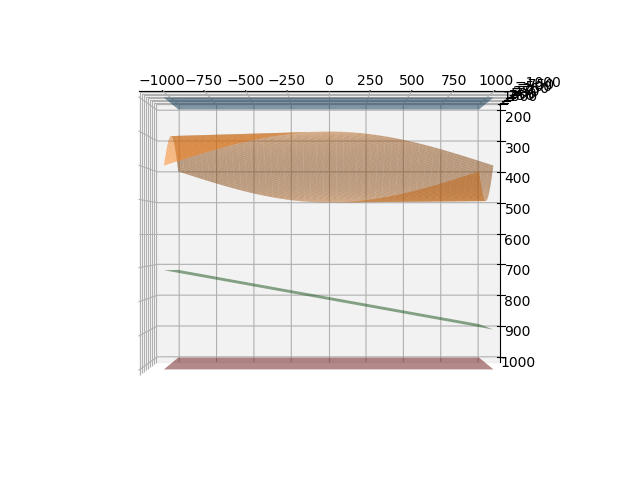

In [33]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

ax.view_init(0, - 90)

model.plot(ax=ax)

## Взаимодействие с моделью и её элементами

Модель состоит из слоёв, каждый из которых характеризуется:
- именем,
- порядковым номером,
- скоростями распространения волн, 
- плотностью,
- двумя ограничивающими горизонтами*

*для первого слоя верхний ограничивающий горизонт расположен на бесконечности, для последнего слоя нижний горизонт - на минус бесконечности

In [10]:
layers = model.layers

print("Имя первого слоя:", layers[0].name)
print("Порядковый номер в модели:", layers[0].number)
print("Скорость P-волн в первом слое =", layers[0].get_velocity()["vp"], "м/с")
print("Скорость S-волн в первом слое =", layers[0].get_velocity()["vs"], "м/с")
print("Плотность пород в первом слое =", layers[0].get_density(), "кг/м^3")

Имя первого слоя: 0
Порядковый номер в модели: 0
Скорость P-волн в первом слое = 2000.0 м/с
Скорость S-волн в первом слое = 1000.0 м/с
Плотность пород в первом слое = 2300.0 кг/м^3


Приписка ["vp"] или ["vs"] после вызова метода необходима, чтобы получить конкретную скорость. Без неё метод возвращает словарь из двух элементов:

In [11]:
layers[0].get_velocity()

{'vp': 2000.0, 'vs': 1000.0}

Вызов плостности не нуждается в дополнительных комментариях.
<hr>
Для вызова горизонтов, ограничивающих данный слой, используются отдельные методы класса Layer. Определённые выше hor_1 и hor_2 ограничивают сверху и снизу второй слой. Вызовем эти горизонты через него:

In [12]:
top_hor = layers[1].top
bottom_hor = layers[1].bottom

**Все горизонты в SeisLab должны являться дважды гладкими функциями вида z = z(x, y)**. В частности, бикубическая интерполяция строится именно из условия непрерывности второй производной.

У таких горизонтов в любой их точке определены:
* Глубина;
* Градиент;
* Нормаль;
* Вторые производные (=> кривизны).

Первые три величины могут быть получены следуюшим образом:

In [13]:
print("Глубина верхнего горизонта в точке с координатами x = 0, y = 0:", top_hor.get_depth(np.array([0, 0])), "м")
print("Градиент функции верхнего горизонта в точке с координатами x = 0, y = 0:",
      top_hor.get_gradient(np.array([0, 0])))
print("Нормаль к верхнему горизонту в точке с координатами x = 0, y = 0:",
      top_hor.get_normal(np.array([0, 0])))

Глубина верхнего горизонта в точке с координатами x = 0, y = 0: 200.0 м
Градиент функции верхнего горизонта в точке с координатами x = 0, y = 0: [ 0.  0.]
Нормаль к верхнему горизонту в точке с координатами x = 0, y = 0: [-0. -0.  1.]


Нормаль к границе строится таким образом, что её компонента по z положительна.

## Создание системы наблюдения (источники, приемники, лучи)

#### 1) Для начала нужно создать нужное количество источников и приемников
#### 2) Для инициализации системы наблюдения нам понадобятся массивы источников и приемников, и скоростная модель

В SeisLab на данный момент реализовано два типа точечных источников сейсмических волн - центр расширения (идеальный источник P-волн) и центр вращения (идеальный источник S-волн). Оба источника излучают в среду импульс Рикера с некоторой главной частотой.

Для создания источника необходимы:
* Главная частота импульса Рикера;
* Модель, в которую источник помещается;
* Координаты источника
* (только для центра вращения) ось вращения.

Создадим источник типа центра расширения, расположенный на поверхности z = 0 в точке с координатами x = 0, y = 0 (т.е. в первом слое). В качестве главной частоты возьмём 25 Гц:

In [14]:
source_freq = 25.0
source_location = np.array([0, 0, 0], dtype=float)

In [15]:
source = tprt.DilatCenter(model, source_freq, source_location)

В дальнейшем рассмотрим 3 сети наблюдения, собственно для этого сначала необходимо создать 3 массива приемников:
1. профиль в координатах $x \in [-800,800]\, м$ с шагом $50 \, м$ и $z=0$, $y=0$;
2. поверхностную сеть наблюдения в квадрате $x,y \in [-800,800]\, м$ с шагом $100 \, м$ по обеим осям и $z=0$;
3. скважинную в точке $(x,y) = (500,500)$ и $z \in [125, 1525] \, м$ с шагом $50 \, м$.

Приёмники характеризуются местоположением и ориентацией. Последнюю можно не задавать явно - по умолчанию оси чувствительности приёмника будут совпадать с осями глобальной системы координат.

**Рекомендуется задавать положения приемников так, чтобы они не лежали ровно на границе раздела каких-то слоев а были немного выше или ниже. Иначе могут возникнуть конфликты при построении лучей**

In [16]:
# Все приемники будут трехкомпонентные с одинаковой ориентацией
orientation = np.array([
    [1, 0, 0],  # axis x
    [0, -1, 0], # axis y
    [0, 0, -1]  # axis z
])

# Профиль приемников
rec_loc_x = np.arange(-800, 800, 100)
receivers_profile = np.empty(rec_loc_x.shape, dtype=tprt.Receiver)
for i, _x in enumerate(rec_loc_x):
    receivers_profile[i] = tprt.Receiver([_x, 0.0, 0.0], orientation=orientation)

# Поверхностная сеть наблюдения
X, Y = np.meshgrid(rec_loc_x, rec_loc_x)
receivers_surface = np.empty(X.shape, dtype=tprt.Receiver)
for i, _x in np.ndenumerate(X):
    receivers_surface[i] = tprt.Receiver([_x, Y[i], 0.0], orientation=orientation)
    
# Скважинная
rec_loc_z = np.arange(125, 1525, 50)
receivers_borehole = np.empty(rec_loc_z.shape, dtype=tprt.Receiver)
for i, _z in enumerate(rec_loc_z):
    receivers_borehole[i] = tprt.Receiver([500.0, 500.0, _z], orientation=orientation)

**В SeisLab предусмотрен задания произвольного луча путем описания его лучевым кодом. Это может быть актуально для рассмотрения обменных волн, головных (только для плоских горизонтов). Для этого есть автоматическая проверка лучевого кода на корректность для данной модели. Однако кастомное задание кода луча является специфической процедурой. Здесь же, для создания лучей мы будем использовать специальный класс Survey который отвечает за автоматический сбор системы наблюдения с её составными частями - лучами. Нам нужно будет только указать, что мы хотим. Пока поддерживается 2 типа волн: отраженные (актуально для поверхностной системы наблюдения) и прямые (для скважинной) монотипные волны.**.

Для инициализации системы наблюдения (Survey) в конструктор необходимо подать:
* Массив источников;
* Массив приёмников;
* Скоростная модель.

Соответственно мы рассмотрим раздельно 3 системы наблюдения: профиль (profile), поверхностную (surface) и скважинную (borehole). Источник оставим везде одним и тем же.

## 1. Система наблюдения состоящая из одного профиля приемников
<hr>
Для начала инициализируем систему наблюдения:

In [17]:
survey_profile = tprt.Survey(source, receivers_profile, model)

После, инициализации Survey, лучи еще не построены. Для инициализации начальных лучей (которые пока не являются реальными) нам необходимо указать:

* тип рассматриваемой волны - vtype ('vp' или 'vs')
* если это отраженная волна то мы должны указать отражающий горизонт - reflect_horizon*
* если это прямая волна - forward = True

*reflect horizon - номер границы относительно положения источника при увеличении глубины.

Так как в модели у нас 4 границы, мы можем рассмотреть отраженную волну от любого горизонта, для примера выберем 2 отраженную от криволинейной границы:

In [18]:
survey_profile.initialize_rays(reflect_horizon=2, vtype='vp', forward=False)

**Созданные только что лучи не являются лучами в строгом понимании этого слова. Их траектория случайна (узлы ломаной находятся на правильных границах, но траектория ломаной не является оптимальной с точки зрения времён пробега), а амплитуды выставлены единичными**. Необходимо оптимизировать полученные лучи и посчитать правильную амплитуду вдоль них. Для этого используется метод Survey.calculate(). Этот метод имеет два аргумента:
* method - метод оптимизации, влияет на скорость сходимости. По умолчанию стоит самый быстрый.
Строго говоря нормальным образом поддерживаются только два: 'Nelder-Mead' (симплексный метод), 'BFGS' (градиентный). По умолчанию стоит BFGS, так как он использует производную вдоль луча, что в разы быстрее чем Nelder-Mead
* survey2D - (boolean). Если True то лучи строятся в вертикальной плоскости Источник-Приемник, если False - то лучи 3-хмерные какими и должны быть. 2-мерная оптмизация работает быстрее чем 3-хмерная, и это становится актуальным если среда близка к горизонтально слоистой.

In [19]:
survey_profile.calculate(method='bfgs', survey2D=False)

Теперь все лучи построены правильно и амплитуды посчитаны. Можно посмотреть сколько лучей у нас есть, обратится к посчитанному массиву времен пробега и построить годографы.

Созданная система наблюдения характеризуется следующими составляющими:
* скоростная модель в которой она существует - ```  survey_profile.velmod ```
* массив источников - ```survey_profile.sources ```
* массив приемников - ```survey_profile.receivers ```
* массив лучей для всех пар источник-приемник - ``` survey_profile.rays ```
* массив времен пробега для всех пар источник-приемник - ``` survey_profile.traveltimes ```
* массив амплитуд волн в приемниках - ``` survey_profile.amplitudes ```
<hr>
Для начала отрисуем систему наблюдения в скоростной модели и посмотреть как выглядят лучи отраженных волн. Отрисовка системы наблюдения выполняется простой командой ``` survey_profile.plot()```, ровно так же как и у скоростной модели.

In [20]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

model.plot(ax=ax)
survey_profile.plot(ax=ax)

<IPython.core.display.Javascript object>

Теперь нарисуем годограф отраженной волны:

In [21]:
T_profile = survey_profile.traveltimes
print(T_profile.shape)

(1, 16)


Размер массива времен имеет два индекса (номер источника, номер приемника), поэтому при отрисовке будем использовать годограф ОПВ соответственно для выбранного источника. У нас он один поэтому просто T[0]

In [22]:
fontsize=13
plt.figure()
plt.title('Годограф отраженной волны от второй границы', fontsize=fontsize)
plt.xlabel('X координата приемника, м', fontsize=fontsize)
plt.ylabel('Время пробега, сек', fontsize=fontsize)
plt.plot(rec_loc_x, T_profile[0])
plt.show()

<IPython.core.display.Javascript object>

Также можно отрисовать амплитуды в приемниках в зависимости от удаления:

In [23]:
A_profile = survey_profile.amplitudes
print(A_profile.shape)

(1, 16, 3)


Размер массива амплитуд имеет три индекса (номер источника, номер приемника, компонента)

In [24]:
fontsize=13
plt.figure()
plt.title('Модуль амплитуды Z компоненты \n отраженной волны от второй границы', fontsize=fontsize)
plt.xlabel('X координата приемника, м', fontsize=fontsize)
plt.ylabel('Амплитуда, м', fontsize=fontsize)
plt.plot(rec_loc_x, abs(A_profile[0, :, -1]))
plt.show()

<IPython.core.display.Javascript object>

Также в модуле предусмотрена возможность отрисовки сейсмограмм, однако пока здесь приведен пример который просто навешивает функцию сейсмического источника на первые вступления, и не рассчитанные амплитуды которые приведены выше. Поэтому это просто демонстрация возможностей

In [25]:
from seislab.src import seislet
from seislab.src.plot_seismic import plot_traces

traces_profile = seislet.seismic_signal(tau=T_profile.T, f=source.fr_dom, dt=0.001, ns=1024)

plot_traces(traces_profile, dt=0.001, 
           offset=rec_loc_x, fill_positive=True)

<IPython.core.display.Javascript object>

** Теперь вернемся к моменту, когда мы выполняли расчет лучей (оптимизацию). Там был дополнительный параметр называемый survey2D, который отвечает за тип оптимизации. Если его поставить True, то лучи будут лежать в вертикальной плоскоски соединяющей пару источник и приемник (т.е. как бы упрощение предполагающее двумерность задачи). Это упрощение позволяет быстрее считать, однако могут накапливаться ошибки. На примере этой системы наблюдения можно посмотреть насколько это влияет на амплитуды и времена пробега. **

Для этого необходимо заново создать систему наблюдения по образу и подобию как это было сделано раньше и выполнить ту же самую последовательность действий.

In [26]:
survey_profile_2d = tprt.Survey(source, receivers_profile, model)
survey_profile_2d.initialize_rays(reflect_horizon=2, vtype='vp', forward=False)

In [27]:
survey_profile_2d.calculate(method='bfgs', survey2D=True)

Как можно видеть расчет был выполнен почти в 2 раза быстрее. Теперь нарисуем что получилось.

In [28]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

model.plot(ax=ax)
survey_profile_2d.plot(ax=ax)

<IPython.core.display.Javascript object>

Посмотрим как отличаются времена пробега и амплитуды

In [29]:
T_profile_2d = survey_profile_2d.traveltimes
A_profile_2d = survey_profile_2d.amplitudes

In [30]:
fontsize=12
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.title('Годограф отраженной волны от второй границы', fontsize=fontsize)
plt.xlabel('X координата приемника, м', fontsize=fontsize)
plt.ylabel('Время пробега, сек', fontsize=fontsize)
plt.plot(rec_loc_x, T_profile[0], label='3D оптимизация')
plt.plot(rec_loc_x, T_profile_2d[0], label='2D оптимизация')
plt.legend(loc='best')

plt.subplot(122)
plt.title('Модуль амплитуды Z компоненты \n отраженной волны от второй границы', fontsize=fontsize)
plt.xlabel('X координата приемника, м', fontsize=fontsize)
plt.ylabel('Амплитуда, м', fontsize=fontsize)
plt.plot(rec_loc_x, abs(A_profile[0, :, -1]), label='3D оптимизация')
plt.plot(rec_loc_x, abs(A_profile_2d[0, :, -1]), label='2D оптимизация')
plt.legend(loc='best')

plt.show()

<IPython.core.display.Javascript object>

Можно видеть что разница есть, но местами она несущественна.

## 2. Поверхностная система наблюдения
<hr>
Далее рассмотрим другие типы систем наблюдения, которые лишь отличаются набором приемников, который задается при инициализации. Такого же подробного описания действий не будет, так как вся последовательность действий абсолютно та же самая.

In [31]:
survey_surface = tprt.Survey(source, receivers_surface, model)
survey_surface.initialize_rays(reflect_horizon=3, vtype='vs', forward=False)
survey_surface.calculate()

..\seislab\src\tprt\ray.py:497: UserWarning: Zero amplitude in the end of segment №1.
 U = [ 0.  0.  0.]
  warnings.warn("Zero amplitude in the end of segment №1.\n U = {}".format(U))
..\seislab\src\tprt\ray.py:497: UserWarning: Zero amplitude in the end of segment №1.
 U = [-0.  0.  0.]
  warnings.warn("Zero amplitude in the end of segment №1.\n U = {}".format(U))
..\seislab\src\tprt\ray.py:497: UserWarning: Zero amplitude in the end of segment №1.
 U = [-0.  0.  0.]
  warnings.warn("Zero amplitude in the end of segment №1.\n U = {}".format(U))
..\seislab\src\tprt\ray.py:497: UserWarning: Zero amplitude in the end of segment №1.
 U = [ 0.  0.  0.]
  warnings.warn("Zero amplitude in the end of segment №1.\n U = {}".format(U))
..\seislab\src\tprt\ray.py:497: UserWarning: Zero amplitude in the end of segment №1.
 U = [-0.  0.  0.]
  warnings.warn("Zero amplitude in the end of segment №1.\n U = {}".format(U))


KeyboardInterrupt: 

In [ ]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

model.plot(ax=ax)
survey_surface.plot(ax=ax)

In [ ]:
T_surface = survey_surface.traveltimes

Для данной системы наблюдения годограф является поверхностным и можно строить например поверхность с помощью способа который мы использовали выше для отображения скоростной модели и системы наблюдения

In [ ]:
fig12 = plt.figure()
ax = Axes3D(fig12)
ax.set_title('Поверхностный годограф \n отраженной волны от 3 границы')
ax.plot_surface(X, Y, T_surface[0])

Однако можно пойти другим путем и рисовать матрицу с помощью уже написанного для таких задач модуля plot_maps в SeisLab

In [ ]:
from seislab.src.plot_maps import plot_map

plot_map(T_surface, x=X, y=Y, 
         title = 'Поверхностный годограф \n отраженной волны от 2 границы',
         add_colorbar=True, interpolation='bilinear')

In [ ]:
traces_surface = seislet.seismic_signal(tau=T_surface[0,:,0:1], f=source.fr_dom, dt=0.001, ns=2500)

plot_traces(traces_surface, dt=0.001, fill_positive=True)

## 3. Скважинная система наблюдения

Посчитаем сразу для Vp и Vs и потом нарисуем "синтетические" сейсмограммы вместе

In [ ]:
survey_borehole_vp = tprt.Survey(source, receivers_borehole, model)
survey_borehole_vs = tprt.Survey(source, receivers_borehole, model)
survey_borehole_vp.initialize_rays(reflect_horizon=None, vtype='vp', forward=True)
survey_borehole_vs.initialize_rays(reflect_horizon=None, vtype='vs', forward=True)

survey_borehole_vp.calculate()
survey_borehole_vs.calculate()

In [ ]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

model.plot(ax=ax)
survey_borehole_vp.plot(ax=ax)

In [ ]:
T_borehole_vp = survey_borehole_vp.traveltimes
T_borehole_vs = survey_borehole_vs.traveltimes

In [ ]:
fontsize=13
plt.figure(figsize=(10,6))
plt.title('Годограф прямой волны', fontsize=fontsize)
plt.xlabel('X координата приемника, м', fontsize=fontsize)
plt.ylabel('Время пробега, сек', fontsize=fontsize)
plt.plot(rec_loc_z, T_borehole_vp[0], label='vp')
plt.plot(rec_loc_z, T_borehole_vs[0], label='vs')
plt.show()

In [ ]:
traces_borehole_vp = seislet.seismic_signal(tau=T_borehole_vp.T, f=source.fr_dom, dt=0.001, ns=2500)
traces_borehole_vs = seislet.seismic_signal(tau=T_borehole_vs.T, f=source.fr_dom, dt=0.001, ns=2500)
traces_borehole = traces_borehole_vs + traces_borehole_vp

plot_traces(traces_borehole,
            dt=0.001,
            offset=rec_loc_z,
            fill_positive=True,
            invert_y_axis=True)